# Stap 1; Include all the things!

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

# Stap 2; get the data

In [12]:
# Set random seed to get the same result after each time running the code
tf.random.set_seed(42)
#print(os.path.dirname(os.path.realpath(__file__)) + "/ods001.csv")
#data = pd.read_csv(os.path.dirname(os.path.realpath(__file__)) + "/ods001.csv", sep = ';', parse_dates=['DateTime'])
data = pd.read_csv("ods001.csv", sep = ';', parse_dates=['DateTime'])

# Stap 3; Orient yourself in the data

In [13]:
print(data.head())
print(data.tail())

                    DateTime Resolution code  Total Load
0  2022-01-10 23:45:00+01:00           PT15M         NaN
1  2022-01-10 23:30:00+01:00           PT15M         NaN
2  2022-01-10 23:15:00+01:00           PT15M         NaN
3  2022-01-10 23:00:00+01:00           PT15M         NaN
4  2022-01-10 22:45:00+01:00           PT15M         NaN
                         DateTime Resolution code  Total Load
246427  2015-01-01 01:00:00+01:00           PT15M     9755.00
246428  2015-01-01 00:45:00+01:00           PT15M     9821.78
246429  2015-01-01 00:30:00+01:00           PT15M     9952.87
246430  2015-01-01 00:15:00+01:00           PT15M    10051.28
246431  2015-01-01 00:00:00+01:00           PT15M    10142.19


# Stap 4; Clean the data to the needed data for your model

In [14]:
data.drop(['Resolution code'], axis = 1,  inplace = True)
data['DateTime'] = pd.to_datetime(data['DateTime'], utc=True).dt.tz_localize(None)
data.index = data['DateTime']
data = data.resample('W', label='left').mean()
print(data.head())
#data.drop(['DateTime'], axis = 1,  inplace = True)
data = data.dropna()

# Select the target
df = data.rename(columns = {'Total Load':'Load'})

              Total Load
DateTime                
2014-12-28   9791.762268
2015-01-04  11394.531548
2015-01-11  11310.602902
2015-01-18  11736.661667
2015-01-25  11406.563988


# Stap 5; Plot it, take a look at how it looks

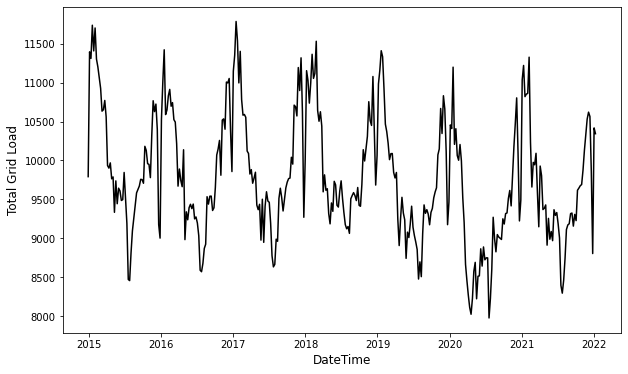

In [15]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Total Grid Load', {'fontsize': 12})
    
dataset = df.copy()
timeseries(df.index, dataset['Load'], 'DateTime')

# Stap 6; Prep for the AI model

In [16]:
# Split train data and test data
train_size = int(len(df)*0.7)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Scale data
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (227, 30, 1)
y_train.shape:  (227, 1)
X_test.shape:  (81, 30, 1)
y_test.shape:  (81, 1)


# Stap 7; Make the AI

In [17]:
model = Sequential() 
model.add(GRU (units = 64, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
model.add(Dropout(0.2)) 
model.add(GRU(units = 64))                 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer='adam',loss='mse')
model_GRU = model
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
history_GRU = model_GRU.fit(X_train, y_train, epochs = 100, validation_split = 0.3, batch_size = 16, shuffle = False, callbacks = [early_stop])

Epoch 1/100
10/10 [==============================] - 10s 249ms/step - loss: 0.0607 - val_loss: 0.0264
Epoch 2/100
10/10 [==============================] - 1s 68ms/step - loss: 0.0280 - val_loss: 0.0187
Epoch 3/100
10/10 [==============================] - 1s 69ms/step - loss: 0.0245 - val_loss: 0.0156
Epoch 4/100
10/10 [==============================] - 1s 68ms/step - loss: 0.0221 - val_loss: 0.0148
Epoch 5/100
10/10 [==============================] - 1s 71ms/step - loss: 0.0223 - val_loss: 0.0142
Epoch 6/100
10/10 [==============================] - 1s 66ms/step - loss: 0.0208 - val_loss: 0.0137
Epoch 7/100
10/10 [==============================] - 1s 71ms/step - loss: 0.0221 - val_loss: 0.0133
Epoch 8/100
10/10 [==============================] - 1s 74ms/step - loss: 0.0195 - val_loss: 0.0129
Epoch 9/100
10/10 [==============================] - 1s 65ms/step - loss: 0.0198 - val_loss: 0.0126
Epoch 10/100
10/10 [==============================] - 1s 64ms/step - loss: 0.0201 - val_loss: 0.01

# Stap 8; Do an evaluation of your AI model

In [18]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.plot()
plot_loss(history_GRU, 'GRU')
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

# Make prediction
prediction = model_GRU.predict(X_test)
prediction_GRU = scaler.inverse_transform(prediction)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (week)')
    plt.ylabel('Total net load')
    plt.show()
       
plot_future(prediction_GRU, 'GRU', y_test)

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

evaluate_prediction(prediction_GRU, y_test, 'GRU')

GRU:
Mean Absolute Error: 421.4941
Root Mean Square Error: 528.6261



# Step 9; Looks good, now predict the future!

X_30.shape:  (338, 30, 1)


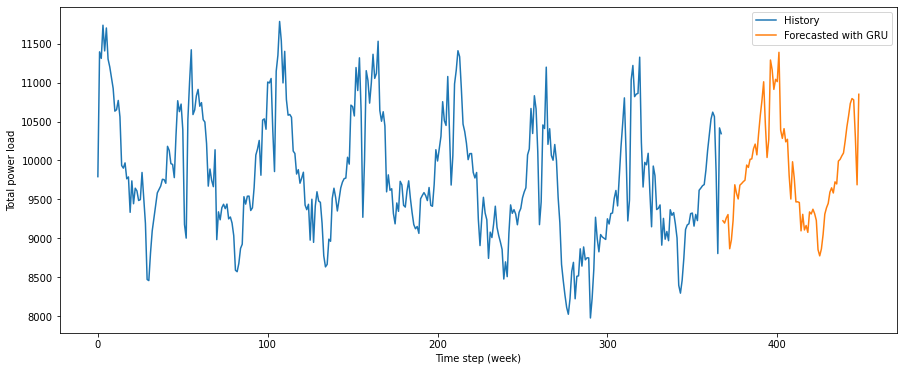

In [19]:
scaled_data = scaler.transform(df)
# Reshape the input 
def create_dataset (X, look_back = 1):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
    return np.array(Xs)

X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape) 

# Make prediction for new data
prediction = model_GRU.predict(X_30)
prediction = scaler.inverse_transform(prediction)
# Plot history and future
def plot_multi_step(history, prediction1):
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with GRU')
    
    plt.legend(loc='upper right')
    plt.xlabel('Time step (week)')
    plt.ylabel('Total power load')
    plt.show()
   
plot_multi_step(df, prediction_GRU)